# Identifying Local Environments in a Complex Crystal

This notebook shows how to use `freud`'s `EnvironmentCluster` class for searching for unique local environments in a complex crystal, $\gamma$-Brass.

"See [Identity crisis in alchemical space drives the entropic colloidal glass transition (Erin Teich, Greg van Anders, Sharon C. Glotzer)](https://www.nature.com/articles/s41467-018-07977-2) for more sophisticated examples of using this environment detection scheme and the definition of a local environment (in the Supplementary Information)."

Prior knowledge of the structure of interest is necessary for selecting parameters and interpreting the results. For example, the $\gamma$-Brass conventional unit cell has 52 particles (26 in primitive cell) and 4 unique Wyckoff sites. The particles in one unit cell may have different number of nearest neighbors (coordination number).

In [11]:
from collections import Counter

import freud
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# Generate a perfect gamma-Brass crystal using its conventional unit cell
a = 2
unit_cell = [a, a, a, 0, 0, 0]
basis_positions = [
    [-0.67226005, -0.67226005, -0.67226005],
    [-0.67226005, -0.32773998, -0.32773998],
    [-0.32773998, -0.32773998, -0.67226005],
    [-0.32773998, -0.67226005, -0.32773998],
    [-0.17225999, -0.17225999, -0.17225999],
    [-0.17225999, -0.82774, -0.82774],
    [-0.82774, -0.82774, -0.17225999],
    [-0.82774, -0.17225999, -0.82774],
    [-0.89219, -0.89219, -0.89219],
    [-0.89219, -0.10780999, -0.10780999],
    [-0.10780999, -0.10780999, -0.89219],
    [-0.10780999, -0.89219, -0.10780999],
    [-0.39218998, -0.39218998, -0.39218998],
    [-0.39218998, -0.60781, -0.60781],
    [-0.60781, -0.60781, -0.39218998],
    [-0.60781, -0.39218998, -0.60781],
    [-0.64421, -1.0, -1.0],
    [-1.0, -0.35579, -1.0],
    [-0.35579, -1.0, -1.0],
    [-1.0, -0.64421, -1.0],
    [-1.0, -1.0, -0.35579],
    [-1.0, -1.0, -0.64421],
    [-0.14420998, -0.5, -0.5],
    [-0.5, -0.85579, -0.5],
    [-0.85579, -0.5, -0.5],
    [-0.5, -0.14420998, -0.5],
    [-0.5, -0.5, -0.85579],
    [-0.5, -0.5, -0.14420998],
    [-0.68844, -0.68844, -0.96326005],
    [-0.68844, -0.31155998, -0.03673998],
    [-0.31155998, -0.31155998, -0.96326005],
    [-0.31155998, -0.68844, -0.03673998],
    [-0.96326005, -0.68844, -0.68844],
    [-0.03673998, -0.68844, -0.31155998],
    [-0.96326005, -0.31155998, -0.31155998],
    [-0.03673998, -0.31155998, -0.68844],
    [-0.68844, -0.03673998, -0.31155998],
    [-0.68844, -0.96326005, -0.68844],
    [-0.31155998, -0.03673998, -0.68844],
    [-0.31155998, -0.96326005, -0.31155998],
    [-0.18844, -0.18844, -0.46326],
    [-0.18844, -0.81156003, -0.53674],
    [-0.81156003, -0.81156003, -0.46326],
    [-0.81156003, -0.18844, -0.53674],
    [-0.46326, -0.18844, -0.18844],
    [-0.53674, -0.18844, -0.81156003],
    [-0.46326, -0.81156003, -0.81156003],
    [-0.53674, -0.81156003, -0.18844],
    [-0.18844, -0.53674, -0.81156003],
    [-0.18844, -0.46326, -0.18844],
    [-0.81156003, -0.53674, -0.18844],
    [-0.81156003, -0.46326, -0.81156003],
]
uc = freud.data.UnitCell(box=unit_cell, basis_positions=basis_positions)
n = 2
noise = 0.0
gb_lattice = uc.generate_system(n, sigma_noise=noise)

The gb lattice has 416 particles


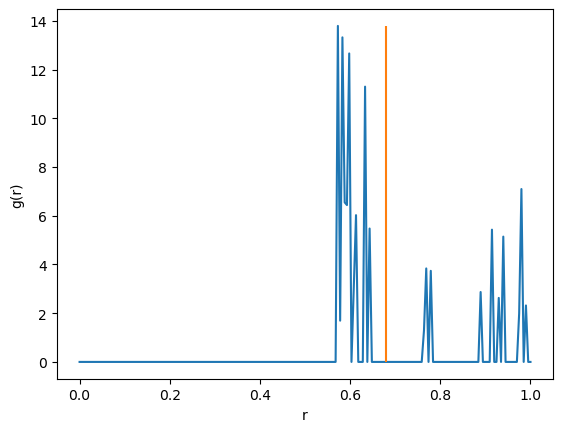

In [13]:
# Plot the rdf for determining the parameters

r_min = 0
r_max = a / 2
nbins = 200

box, points = gb_lattice
print(f"The gb lattice has {len(points)} particles")
rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
rdf.compute((box, points))

fig, ax = plt.subplots()
ax.plot(np.linspace(r_min, r_max, nbins), rdf.rdf)
ax.set_xlabel("r")
ax.set_ylabel("g(r)")
plt.vlines(0.68, 0, max(rdf.rdf), colors="C1")
plt.show()

Notice that the first well appears at around r = 0.68. We use this as the cut off radius for `env_neighbor`. We do not use `num_neighbors` here for `env_neighbor` because as mentioned above, the particles in the $\gamma$-Brass structure may have different coordination numbers, unlike particles in simpler crystals such as BCC (coordination number = 8).

For the `neighbor` parameter, which specifies the number of neighbors the environment cluster of each particle will be compared against with, we choose arbitrarily `{'num_neighbors': 20}` because we set `global_search=True`. When `global_search=True`, the neighbor list provided to `neighbor` is ignored and environments of every single pair of particles in the system are compared. Since this system contains only 416 particles, the search does not slow down the computation significantly.

In [14]:
first_well = 0.68
env_cluster = freud.environment.EnvironmentCluster()

threshold = 0.2 * first_well
# neighbor = {"num_neighbors": 20}
env_neighbor = {"r_max": first_well}
nlist = freud.locality.NeighborList.all_pairs((box, points))

env_cluster.compute(
    (box, points),
    threshold=threshold,
    cluster_neighbors=nlist,
    env_neighbors=env_neighbor,
    registration=False,
)

print(f"Number of particles that belong to each cluster:")
print(list(Counter(env_cluster.cluster_idx).values()))

AttributeError: type object 'freud.locality.NeighborList' has no attribute 'all_pairs'

From the figure above, we can see that 26 different clusters were found, with each containing 16 particles. Next we try with `registration=True`, which means that particles whose environments differ only by orientation will be in the same cluster. 

In [ ]:
first_well = 0.68
env_cluster = freud.environment.EnvironmentCluster()

threshold = 0.2 * first_well
neighbor = {"num_neighbors": 20}
env_neighbor = {"r_max": first_well}

env_cluster.compute(
    (box, points),
    threshold=threshold,
    cluster_neighbors=nlist,
    env_neighbors=env_neighbor,
    registration=True,
)

fig, ax = plt.subplots()
ax.hist(
    env_cluster.cluster_idx,
    bins=range(env_cluster.num_clusters + 1),
    align="left",
    rwidth=0.3,
)
ax.set_xlabel("Cluster keys")
ax.set_ylabel("Number of particles")
plt.title("Cluster Frequency")
plt.show()

Next we plot the number of particles that make up a cluster.

In [7]:
for i in range(env_cluster.num_clusters):
    num_particles = 0
    for vector in env_cluster.cluster_environments[i]:
        if np.power(vector, 2).sum() > 0:
            num_particles += 1
    print(f"Coordination number of cluster {i}: {num_particles}")

Coordination number of cluster 0: 12
Coordination number of cluster 1: 12
Coordination number of cluster 2: 12
Coordination number of cluster 3: 12
Coordination number of cluster 4: 12
Coordination number of cluster 5: 12
Coordination number of cluster 6: 12
Coordination number of cluster 7: 12
Coordination number of cluster 8: 12
Coordination number of cluster 9: 12
Coordination number of cluster 10: 12
Coordination number of cluster 11: 12
Coordination number of cluster 12: 12
Coordination number of cluster 13: 12
Coordination number of cluster 14: 12
Coordination number of cluster 15: 12
Coordination number of cluster 16: 12
Coordination number of cluster 17: 12
Coordination number of cluster 18: 12
Coordination number of cluster 19: 12
Coordination number of cluster 20: 12
Coordination number of cluster 21: 12
Coordination number of cluster 22: 12
Coordination number of cluster 23: 12
Coordination number of cluster 24: 12
Coordination number of cluster 25: 12
Coordination number of

Coordination number of cluster 366: 11
Coordination number of cluster 367: 11
Coordination number of cluster 368: 11
Coordination number of cluster 369: 11
Coordination number of cluster 370: 11
Coordination number of cluster 371: 11
Coordination number of cluster 372: 11
Coordination number of cluster 373: 11
Coordination number of cluster 374: 11
Coordination number of cluster 375: 11
Coordination number of cluster 376: 11
Coordination number of cluster 377: 11
Coordination number of cluster 378: 11
Coordination number of cluster 379: 11
Coordination number of cluster 380: 11
Coordination number of cluster 381: 11
Coordination number of cluster 382: 11
Coordination number of cluster 383: 11
Coordination number of cluster 384: 11
Coordination number of cluster 385: 11
Coordination number of cluster 386: 11
Coordination number of cluster 387: 11
Coordination number of cluster 388: 11
Coordination number of cluster 389: 11
Coordination number of cluster 390: 11
Coordination number of cl

From the figure above, we can see that indeed the particles have different coordination numbers. Next we use `gsd` to save the snapshot and `fresnel` to visualize it.

In [5]:
import gsd.hoomd

typeid = env_cluster.cluster_idx.copy()
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = len(points)
snapshot.particles.position = points
snapshot.particles.types = [str(i) for i in np.unique(typeid)]
snapshot.particles.typeid = typeid
snapshot.particles.diameter = np.ones(len(points))
snapshot.configuration.box = [box.Lx, box.Ly, box.Lz, box.xy, box.xz, box.yz]
with gsd.hoomd.open(f"gb_lattice.gsd", mode="wb") as f:
    f.append(snapshot)

In [6]:
import fresnel

# Color particles by different local environments identified
type_colors = np.array(
    [
        fresnel.color.linear([0.99, 0, 0]),
        fresnel.color.linear([0.99, 0.99, 0]),
        fresnel.color.linear([0, 0.93, 0.95]),
    ]
)
colors = type_colors[typeid]

scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(scene, N=snapshot.particles.N, radius=0.2)
geometry.position[:] = snapshot.particles.position
geometry.material = fresnel.material.Material(roughness=0.9)
geometry.outline_width = 0.02

geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

fresnel.geometry.Box(scene, box, box_radius=0.02)

scene.camera = fresnel.camera.Orthographic.fit(scene)
scene.lights = fresnel.light.lightbox()
fresnel.pathtrace(scene, light_samples=5)

IndexError: index 3 is out of bounds for axis 0 with size 3